## retrans packets

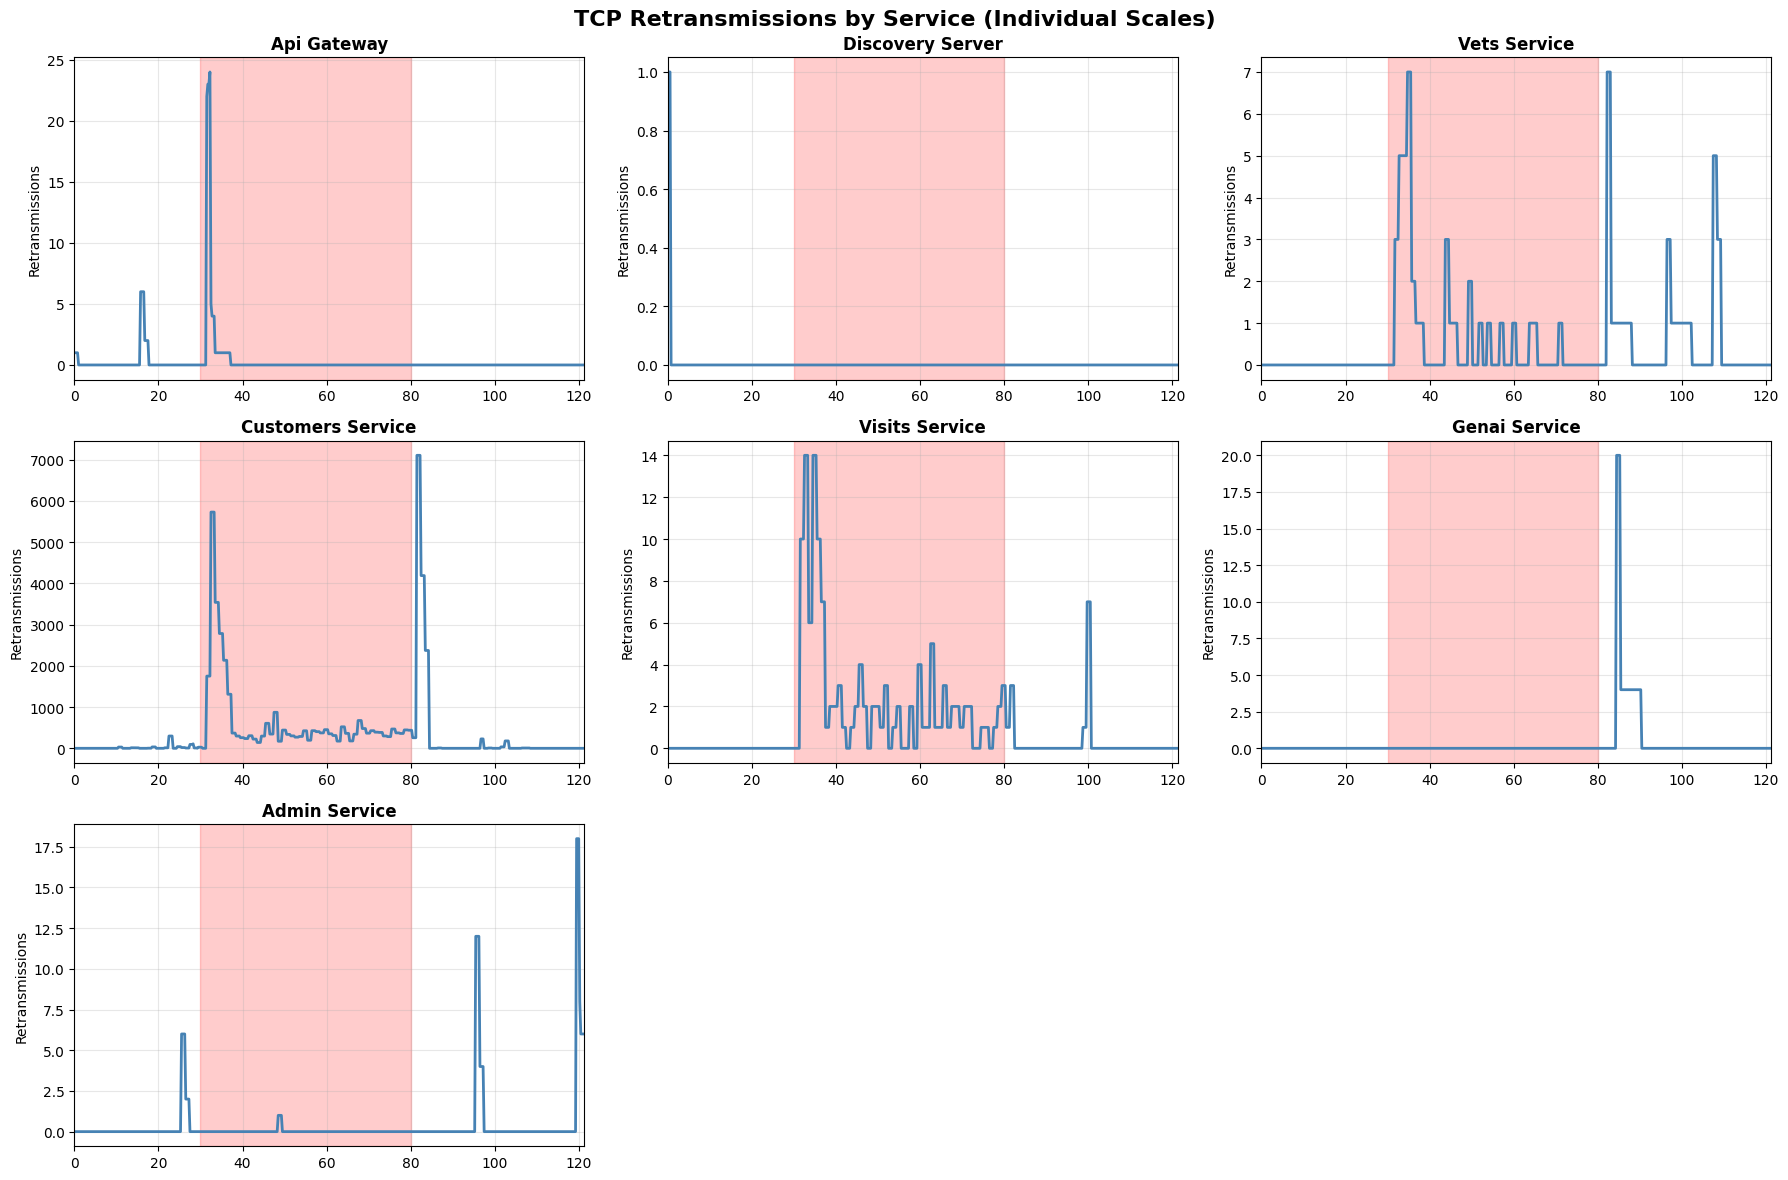

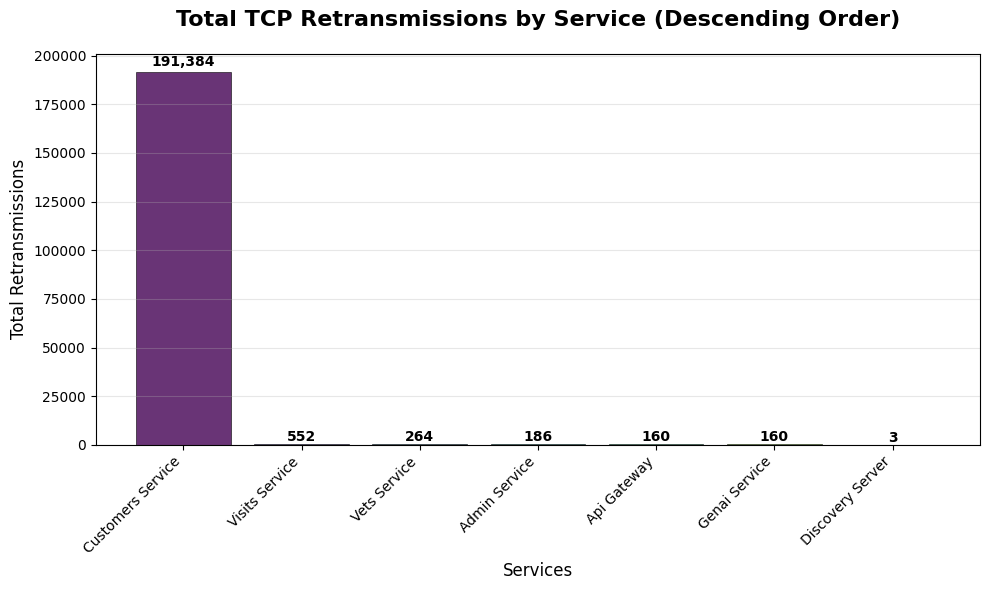

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df_tcp_retrans = pd.read_csv("retrans_packets.csv")

df_tcp_retrans["Time"] = pd.to_datetime(df_tcp_retrans["Time"])

df_tcp_retrans["Minutes"] = (df_tcp_retrans["Time"] - df_tcp_retrans["Time"].min()).dt.total_seconds() / 60

service_groups = {
  'api_gateway': [col for col in df_tcp_retrans.columns if 'api_gateway' in col],
  'discovery_server': [col for col in df_tcp_retrans.columns if 'discovery_server' in col],
  'config_server': [col for col in df_tcp_retrans.columns if 'config_server' in col],
  'vets_service': [col for col in df_tcp_retrans.columns if 'vets' in col],
  'customers_service': [col for col in df_tcp_retrans.columns if 'customers' in col],
  'visits_service': [col for col in df_tcp_retrans.columns if 'visits' in col],
  'genai_service': [col for col in df_tcp_retrans.columns if 'genai' in col],
  'admin_service': [col for col in df_tcp_retrans.columns if 'admin' in col],
  'localhost': [col for col in df_tcp_retrans.columns if 'localhost' in col]
}

# Create aggregated columns by summing all instances of each service
for service_name, columns in service_groups.items():
  if columns:  
      df_tcp_retrans[f'{service_name}_total'] = df_tcp_retrans[columns].sum(axis=1)

aggregated_cols = [f'{service}_total' for service in service_groups.keys() 
                 if any(col in df_tcp_retrans.columns for col in service_groups[service])]

df_tcp_retrans['Total_retrans'] = df_tcp_retrans[aggregated_cols].sum(axis=1)

delay_start = 30  
delay_duration = 50  

active_services = [col for col in aggregated_cols if df_tcp_retrans[col].sum() > 0]
n_services = len(active_services)
n_cols = 3
n_rows = (n_services + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 4*n_rows))
axes = axes.flatten() if n_services > 1 else [axes]

for i, col in enumerate(active_services):
  service_name = col.replace('_total', '').replace('_', ' ').title()
  axes[i].plot(df_tcp_retrans["Minutes"], df_tcp_retrans[col], 
              linewidth=2, color='steelblue')
  axes[i].set_title(f"{service_name}", fontsize=12, fontweight='bold')
  axes[i].set_ylabel("Retransmissions")
  axes[i].grid(True, alpha=0.3)
  axes[i].axvspan(delay_start, delay_start + delay_duration, color='red', alpha=0.2)
  axes[i].set_xlim(0, df_tcp_retrans["Minutes"].max())

for i in range(n_services, len(axes)):
  axes[i].set_visible(False)

plt.suptitle("TCP Retransmissions by Service (Individual Scales)", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Services ranked by total retransmissions
service_totals = {}
for col in aggregated_cols:
   if df_tcp_retrans[col].sum() > 0:
       service_name = col.replace('_total', '').replace('_', ' ').title()
       service_totals[service_name] = df_tcp_retrans[col].sum()

service_totals_sorted = pd.Series(service_totals).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
colors = plt.cm.viridis(np.linspace(0, 1, len(service_totals_sorted)))
bars = plt.bar(range(len(service_totals_sorted)), service_totals_sorted.values, 
              color=colors, alpha=0.8, edgecolor='black', linewidth=0.5)
plt.title("Total TCP Retransmissions by Service (Descending Order)", 
         fontsize=16, fontweight='bold', pad=20)
plt.xlabel("Services", fontsize=12)
plt.ylabel("Total Retransmissions", fontsize=12)
plt.xticks(range(len(service_totals_sorted)), service_totals_sorted.index, 
          rotation=45, ha='right')

for i, (bar, value) in enumerate(zip(bars, service_totals_sorted.values)):
   plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + value*0.01, 
            f'{int(value):,}', ha='center', va='bottom', fontweight='bold')

plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()